In [28]:
import numpy as np
import pandas as pd

import torch

from matplotlib import pyplot as plt

from collections import deque

from pid import PIDModel
from agent import Agent, Actor, Critic, Transition

%matplotlib inline

## Loading up Actor and Critic models

In [30]:
T_SIZE = 500
SET_POINT = 50

t = np.linspace(0, 50, num=T_SIZE)
SP = np.ones(T_SIZE)*SET_POINT

env = PIDModel(ku=1.396, tu=3.28, t=t, SP=SP)

actor = Actor()
critic = Critic()
agent = Agent(env,
    actor_lr=0, critic_lr=0,
    actor_model=actor, critic_model=critic,
    device=args["DEVICE"], gamma=0.95)


print(agent.get_action(torch.Tensor([0.5, 0.5, 3, 10, 10])))
agent.load()
print(agent.get_action(torch.Tensor([0.5, 0.5, 50, 0, 1000])))

tensor([0.1192, 0.3278, 2.7031], grad_fn=<AddBackward0>)
tensor([1., 1., 2.], grad_fn=<AddBackward0>)


Emulating some episodes
---

In [31]:
state = env.reset()
done = False
total = 0

agent.start_episode()
state, init_reward, __ = env.step((0.5, 0.5, 3.5))  # Initial random state
num_step = 0
rewards = [init_reward]
states = [state]
while not done:
    action = agent.get_action(state)

    new_state, reward, done = env.step(action)
    transition = Transition(
        reward=reward, state=state,
        action=action, target_action=action,
        next_state=new_state)
    agent.step(transition)

    total += reward
    state = new_state
    num_step += 1
    rewards.append(reward)
    states.append(state)

y_caps = np.array(env.output())

In [32]:
states

[(0.5, 0.5, 3.5, 50.0, 499.0),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  49.8018686775805,
  -1.9773505977466015),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  48.68200165579196,
  -11.176272877449664),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  46.59424134880675,
  -20.835847863712395),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  43.7547011784758,
  -28.338610899902868),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  40.431298244592185,
  -33.167561280158466),
 (tensor(1., grad_fn=<SelectBackward>),
  tensor(1., grad_fn=<SelectBackward>),
  tensor(2., grad_fn=<SelectBackward>),
  36.911911599905416,
  -

In [33]:
y_caps

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.98131322e-01,  5.81126537e+00,  1.11099310e+02],
       ...,
       [ 4.99999978e+01, -5.32931728e-07,  2.23313111e-07],
       [ 4.99999978e+01, -5.09554788e-07,  2.34916618e-07],
       [ 4.99999977e+01, -4.86016048e-07,  2.34916618e-07]])

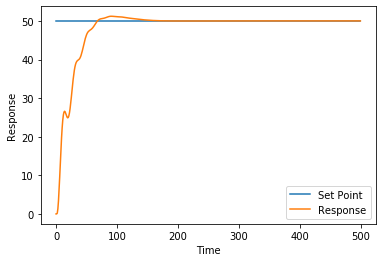

In [42]:
response = y_caps[:, 0]

plt.plot(SP, label="Set Point")
plt.plot(response, label="Response")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Response")
plt.savefig('trained_response.png')

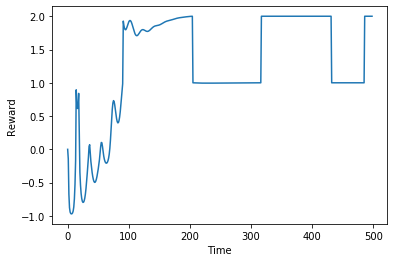

In [43]:
plt.plot(rewards)
plt.ylabel("Reward")
plt.xlabel("Time")
plt.savefig("trained_reward.png")

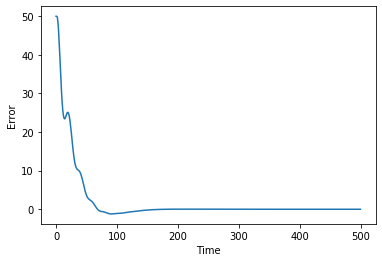

In [44]:
error = SP-response
plt.plot(error)
plt.xlabel("Time")
plt.ylabel("Error")
plt.savefig("trained_error.png")

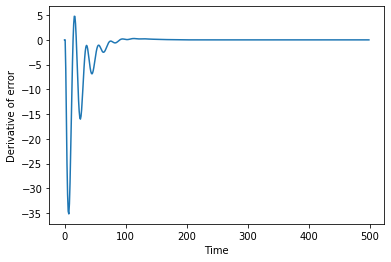

In [45]:
d_error = -y_caps[:, 1]
plt.plot(d_error)
plt.xlabel("Time")
plt.ylabel("Derivative of error")
plt.savefig("trained_de_t.png")

In [38]:
# Max overshoot
error_pd = -pd.Series(error)

# Max overshoot is when |error| is maximum after touching the set point first, i.e after first crossing zero
first_cross = error_pd[((error_pd.shift() <= 0) & (error_pd >= 0))].index[0]

print("Max overshoot: ", error_pd[first_cross: ].abs().max())

Max overshoot:  1.2076750650028032


In [41]:
# Settling time: first occurence of when tolerance band is reached
# tolerance band is +-TOLERANCE_BAND percent of the target set point

TOLERANCE_BAND = 5/100 # Within 5% of the target is tolerable
abs_tolerance = TOLERANCE_BAND*SP[0]

settling_time = t[error_pd[(error_pd.abs() < abs_tolerance)].index[0]]
print("Settling time (5%): ", settling_time)

Settling time (5%):  5.511022044088176


In [40]:
# Settling time: first occurence of when tolerance band is reached
# tolerance band is +-TOLERANCE_BAND percent of the target set point

TOLERANCE_BAND = 2/100 # Within 5% of the target is tolerable
abs_tolerance = TOLERANCE_BAND*SP[0]

settling_time = t[error_pd[(error_pd.abs() < abs_tolerance)].index[0]]
print("Settling time (2%): ", settling_time)

Settling time (2%):  6.412825651302605
